# Lab Session 5 : Classification II

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [2]:
#  Read Data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## 1. Data Analysis

### Load the top 5 lines of dataset.  


## Titanic Dataset Overview

Each row in `train_data` represents one passenger onboard the Titanic. We have 12 columns in total:

- **Features (11):**  
  `PassengerId`, `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, `Embarked`
- **Label (1):**  
  `Survived`

---

## Feature vs. Label

- **Label (`Survived`):**  
  A binary indicator (0 = did not survive; 1 = survived).  
- **Features:**  
  Variables used to predict survival.

---

## Column Descriptions

| Column       | Data Type  | Description                                                                                      |
|--------------|------------|--------------------------------------------------------------------------------------------------|
| PassengerId  | Integer    | Unique identifier for each passenger (ordering only; not predictive).                             |
| Survived     | Integer    | Survival flag (0 = No, 1 = Yes).                                                    |
| Pclass       | Integer    | Ticket class (1 = Upper / Upper middle, 2 = Middle, 3 = Lower).                                  |
| Name         | String     | Passenger’s full name.                                                                            |
| Sex          | String     | Gender (“male” or “female”).                                                                      |
| Age          | Float      | Age in years (fractional values indicate months for infants).                                     |
| SibSp        | Integer    | # of siblings and spouses aboard (brothers, sisters, husbands, wives).                            |
| Parch        | Integer    | # of parents and children aboard (parents, children, step-relationships).                         |
| Ticket       | String     | Ticket number (may contain letters and digits).                                                   |
| Fare         | Float      | Passenger fare (British pounds).                                                                  |
| Cabin        | String     | Cabin number (deck and room; many missing values).                                                |
| Embarked     | String     | Port of embarkation:  
  - C = Cherbourg  
  - Q = Queenstown  
  - S = Southampton                                                                                 

---

## Data Types & Preprocessing

- **Numeric features:**  
  `Pclass`, `Age`, `SibSp`, `Parch`, `Fare`  
  > These can be fed directly into many ML algorithms without scaling, though normalization or binning (e.g., grouping ages) can help.

- **Categorical / Text features:**  
  `Sex`, `Ticket`, `Cabin`, `Embarked`, `Name`  
  - **`Sex`**, **`Embarked`**: one-hot encoding or label encoding  
  - **`Name`**: extract title (Mr, Mrs, Miss, etc.) or length; drop the rest  
  - **`Ticket`**: extract prefix (if any) or ticket frequency  
  - **`Cabin`**: extract deck letter, fill missing as “Unknown”

- **Identifier:**  
  `PassengerId`  
  > Not predictive—drop before training.

In [3]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Unlike train_data, there is no "Survived" information corresponding to the label because test_data is data used to verify the model.  

In [4]:
test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Feature Distributions & Interpretations

These summary values help us grasp the overall distribution of each feature and draw meaningful conclusions:

- For both **SibSp** (number of siblings/spouses aboard) and **Parch** (number of parents/children aboard), the 75th percentile is 0 or 1.  
  → **Interpretation:** Most passengers sailed without any family members on board.

- You’ll also notice that the **scale** of each feature differs substantially (for example, `Fare` can range into the hundreds while `Pclass` is only 1–3).  
  → **Implication:** Some features may require normalization or scaling before feeding into certain machine-learning models.


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Need to Check the Null data

In [6]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Descriptive Statistics Overview

When we run `train_data.describe()` (or `Series.describe()`) on our columns, we get four key statistics for categorical/object columns:

| Statistic | Meaning                                                 |
|-----------|---------------------------------------------------------|
| **count** | Number of non-null entries                              |
| **unique**| Number of distinct values                               |
| **top**   | Most frequent value                                     |
| **freq**  | Frequency of the most frequent value                    |

For our Titanic training set (891 rows total):

### 1. count  
- **Most columns:** 891 non-null entries (no missing data).  
- **Cabin:** only 204 non-null entries → 687 missing values.  
- **Embarked:** 889 non-null entries → 2 missing values.

### 2. unique  
- **Name:** 891 unique names (each passenger is distinct).  
- **Sex:** 2 distinct values (`male`, `female`).  
- **Ticket:** 681 unique tickets (some passengers share tickets).  
- **Cabin:** 147 unique cabin identifiers.  
- **Embarked:** 3 ports (`C`, `Q`, `S`).

### 3. top & freq  
- **Name:** `top` is arbitrary (all are unique), and `freq = 1`.  
- **Sex:** `top = male`, `freq = 577` → 577 men and 314 women.  
- **Embarked:** `top = S` (Southampton), `freq = 644` → 644 passengers boarded at Southampton.

---

### Interpretation

- The high **missing rate** in **Cabin** and **Embarked** suggests we’ll need to impute or handle those gaps.  
- The **unique** counts show which features carry almost no repetition (e.g., `Name`) versus those with reuse (e.g., `Ticket`).  
- The **top/freq** pair highlights class imbalance (e.g., far more males than females, majority embarked from `S`).  


In [7]:
train_data.describe(include=['O']) #object

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


## Feature–Target Relationship & Initial Hypotheses

Before diving into the data, let’s articulate a couple of hypotheses about how our features might relate to survival:

1. **Family Aboard (SibSp & Parch):**  
   - **Hypothesis:** Passengers traveling with more family members (higher `SibSp` or `Parch`) will have a **lower** survival rate.  
   - **Rationale:** Coordinating a group evacuation under stress may slow individuals down, reducing their chance of getting to safety quickly.

2. **Passenger Class (Pclass):**  
   - **Hypothesis:** Passengers in **first class** (`Pclass = 1`) will have a **higher** survival rate than those in second (`Pclass = 2`) or third class (`Pclass = 3`).  
   - **Rationale:** First-class passengers had better access to lifeboats and shorter evacuation routes, whereas lower-class passengers were farther from the deck and below in the ship’s hierarchy.


In [8]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### We can also represent this in graph.


#####  The results show that the higher the ticket rating, the higher the survival rate.

<Axes: xlabel='Pclass', ylabel='count'>

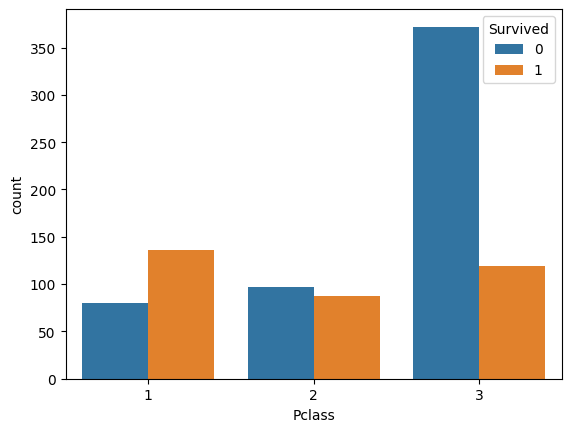

In [9]:
sns.countplot(data=train_data, x="Pclass", hue="Survived")

## Family Size & Preprocessing

### Observations
- **SibSp** (siblings/spouses aboard) and **Parch** (parents/children aboard) both show that **lower counts** tend to correspond with **higher survival rates**.
- However, there’s no simple linear trend for every individual count, and using both separately can introduce redundancy.

In [10]:
train_data[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=True)

,Survived
SibSp,
8,0.000000
5,0.000000
4,0.166667
3,0.250000
0,0.345395
2,0.464286
1,0.535885


In [11]:
train_data[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by='Survived', ascending=True)

,Survived
Parch,
6,0.000000
4,0.000000
5,0.200000
0,0.343658
2,0.500000
1,0.550847
3,0.600000


## 2. Preprocessing

### 1. Create `FamilySize` Feature

We’ll combine **SibSp** and **Parch** into one column that captures the total family members aboard:

```python
# Combine siblings/spouses and parents/children into a single feature
df['FamilySize'] = df['SibSp'] + df['Parch']


In [12]:
# Read Data
preprocessing_train_data = pd.read_csv('train.csv')
preprocessing_test_data = pd.read_csv('test.csv')

# Add "SibSp" and "Parch" to make "FamilySize"
preprocessing_train_data['FamilySize'] = preprocessing_train_data['SibSp'] + preprocessing_train_data['Parch']
preprocessing_test_data['FamilySize'] = preprocessing_test_data['SibSp'] + preprocessing_test_data['Parch']

# Delete "SibSp" abd "Parch"
preprocessing_train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
preprocessing_test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Print top 5 values
preprocessing_train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [13]:
preprocessing_train_data[['FamilySize', 'Survived']].groupby(['FamilySize']).mean().sort_values(by='Survived', ascending=True)

,Survived
FamilySize,
7,0.000000
10,0.000000
5,0.136364
4,0.200000
0,0.303538
6,0.333333
1,0.552795
2,0.578431
3,0.724138


### 2. Binarize `FamilySize` into a Simple Indicator

> **Caveat:**  
> This binarization is **not necessarily optimal**.  
> - Passengers with **zero** family members sometimes have a **lower** survival rate than those with **six** family members, so we lose that nuance.  
> - Preprocessing choices are highly diverse, and they **directly impact** model performance.  
> - Here, we’ve deliberately made omissions to keep the model **as simple as possible**.

**Implementation:**  
Convert every `FamilySize` value to:
- `1` if **> 4** (large family)  
- `0` if **≤ 4** (small or no family)

```python
# Create a binary “large family” flag
df['IsLargeFamily'] = (df['FamilySize'] > 4).astype(int)


In [14]:
# Divide "Family size" into 0 and 1 based on 4
preprocessing_train_data.loc[preprocessing_train_data['FamilySize'] <= 4, 'FamilySize'] = 0
preprocessing_train_data.loc[preprocessing_train_data['FamilySize'] > 4, 'FamilySize'] = 1

preprocessing_test_data.loc[preprocessing_test_data['FamilySize'] <= 4, 'FamilySize'] = 0
preprocessing_test_data.loc[preprocessing_test_data['FamilySize'] > 4, 'FamilySize'] = 1

# Print top 5 valus
preprocessing_train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,W./C. 6607,23.4500,NaN,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C148,C,0


In [15]:
# Statistics between "FamilySize" and "Survived"
preprocessing_train_data[['FamilySize', 'Survived']].groupby(['FamilySize']).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
0,0.396919
1,0.148936


### 3. Extract `Title` and Remove Unnecessary Columns

`Name`, `Ticket`, and `Cabin` are textual fields that do not directly predict survival. However, **titles** embedded in `Name` (e.g., `Mr`, `Mrs`, `Miss`, `Master`, `Dr`, `Capt`) carry useful information about age, gender, and social status. We will extract a new `Title` feature and then drop the original text columns.



In [17]:
# Extract "Name" and create "Title"
preprocessing_train_data['Title'] = preprocessing_train_data.Name.str.extract('([A-Za-z]+)\.', expand=False)
preprocessing_test_data['Title'] = preprocessing_test_data.Name.str.extract('([A-Za-z]+)\.', expand=False)

# Delete "Name", "Ticket", "Cabin" features
preprocessing_train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
preprocessing_test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Print statistics of "Title"
pd.crosstab(preprocessing_train_data['Title'], preprocessing_train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


### 4. Encode `Title` Feature

There are very few passengers with titles other than `Master`, `Mr`, `Mrs`, and `Miss`. We will:

1. **Consolidate titles**  
   - Replace any title not in `['Master','Mr','Mrs','Miss']` with `Rare`.  
   - Merge female variants `['Mlle','Ms','Mme']` into `Miss`.

2. **Map titles to numeric codes**  
   - `Mr` → 1  
   - `Miss` → 2  
   - `Mrs` → 3  
   - `Master` → 4  
   - `Rare` → 5  
   - Unknown → 0

3. **Apply mapping and ensure integer type**

- **`.replace(...)`** merges `Mlle`, `Ms`, and `Mme` into `"Miss"`.  



In [19]:
#The rest except the main "Title" is classified as "Rare"
preprocessing_train_data['Title'].replace(['Lady', 'Countess', 'Capt','Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)
preprocessing_test_data['Title'].replace(['Lady', 'Countess', 'Capt','Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)

# Unify 'Ms', 'Mlle', 'Mme' as 'Miss'
preprocessing_train_data['Title'].replace(['Ms', 'Mlle', 'Mme'], 'Miss', inplace=True)
preprocessing_test_data['Title'].replace(['Ms', 'Mlle', 'Mme'], ['Miss', 'Miss', 'Miss'], inplace=True)

# "Title" vectorization
preprocessing_train_data['Title'].replace(['Mr', 'Miss', 'Mrs', 'Master', 'Rare'], [1, 2, 3, 4, 5], inplace=True)
preprocessing_test_data['Title'].replace(['Mr', 'Miss', 'Mrs', 'Master', 'Rare'], [1, 2, 3, 4, 5], inplace=True)

# Set '0' for unknown "Title"
preprocessing_train_data['Title'].replace([None], [0], inplace=True)
preprocessing_test_data['Title'].replace([None], [0], inplace=True)

# Print top 5 values
preprocessing_train_data.head()

<ipython-input-19-f994c1b942cf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preprocessing_train_data['Title'].replace(['Lady', 'Countess', 'Capt','Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)
<ipython-input-19-f994c1b942cf>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,male,22.0,7.2500,S,0,1
1,2,1,1,female,38.0,71.2833,C,0,3
2,3,1,3,female,26.0,7.9250,S,0,2
3,4,1,1,female,35.0,53.1000,S,0,3
4,5,0,3,male,35.0,8.0500,S,0,1


## 5. Handle `Sex` and `Embarked` Features

`Sex` and `Embarked` are directly related to passenger survival and require minimal preprocessing:

1. **Fill missing `Embarked` values**  
   - Replace the 2 missing entries with the most common port: `'S'` (Southampton).

2. **Map `Sex` to numeric codes**  
   - `'female'` → `0`  
   - `'male'`   → `1`

3. **Map `Embarked` to numeric codes**  
   - `'Q'` → `0`  
   - `'C'` → `1`  
   - `'S'` → `2`

In [20]:
# Fill unknown "Embarked" to 'S'
preprocessing_train_data['Embarked'].replace([None], ['S'], inplace=True)
preprocessing_test_data['Embarked'].replace([None], ['S'], inplace=True)

# "Embarked", "Sex" vectorization
preprocessing_train_data.replace(['female', 'male'], [0, 1], inplace=True)
preprocessing_train_data.replace(['Q', 'C', 'S'], [0, 1, 2], inplace=True)

preprocessing_test_data.replace(['female', 'male'], [0, 1], inplace=True)
preprocessing_test_data.replace(['Q', 'C', 'S'], [0, 1, 2], inplace=True)

# Print top 5 values
preprocessing_train_data[['Sex', 'Embarked']].head()

<ipython-input-20-20925062eea7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preprocessing_train_data['Embarked'].replace([None], ['S'], inplace=True)
<ipython-input-20-20925062eea7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

,Sex,Embarked
0,1,2
1,0,1
2,0,2
3,0,2
4,1,2


## 6. Impute Missing `Age` Values

The `Age` feature has 177 missing entries. We will replace these with the mean age of the remaining passengers.

In [21]:
preprocessing_train_data['Age'].fillna(preprocessing_train_data['Age'].mean(), inplace=True)
preprocessing_test_data['Age'].fillna(preprocessing_train_data['Age'].mean(), inplace=True)

<ipython-input-21-d30dfdecf810>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preprocessing_train_data['Age'].fillna(preprocessing_train_data['Age'].mean(), inplace=True)
<ipython-input-21-d30dfdecf810>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

## Final Feature Set & Standardization

Our final dataset consists of these seven features:

- **Title**  
- **Pclass**  
- **Sex**  
- **Age**  
- **Fare**  
- **Embarked**  
- **FamilySize**  

Since **Age** and **Fare** span very different ranges and can dominate model training, we apply **standardization** to both (zero mean, unit variance). This ensures faster convergence for gradient‐based methods and balanced influence among features. (Normalization are omitted in this lab session.)

In [22]:
# need to check the null value
print(preprocessing_train_data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
FamilySize     0
Title          0
dtype: int64


In [23]:
preprocessing_train_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,32.204208,1.638608,0.052750,1.727273
std,257.353842,0.486592,0.836071,0.477990,13.002015,49.693429,0.635673,0.223659,1.029196
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,7.910400,1.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,29.699118,14.454200,2.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,31.000000,2.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,1.000000,5.000000


## 3.  Machine Learning

We will train two classifiers on the preprocessed data: **Logistic Regression**.

1. **Prepare Data**  
   - **Features (`X_train`)**: All columns except `Survived` and `PassengerId` from the training set.  
   - **Labels (`y_train`)**: The `Survived` column.  
   - **Test Features (`X_test`)**: All columns except `PassengerId` from the test set.

2. **Train Models**  
   - **Logistic Regression**  
   - **SVM**

3. **Make Predictions**  
   - Use each trained model to predict `Survived` on `X_test`.


In [24]:
# Creating data for training
X_train = preprocessing_train_data.drop(['Survived', 'PassengerId'], axis=1)
Y_train = preprocessing_train_data["Survived"]
X_test = preprocessing_test_data.drop(['PassengerId'], axis=1)

In [25]:
classifier = LogisticRegression()

#### Fit the classifier to the training data


In [27]:
classifier.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

After training our **Logistic Regression** models, we assess them using three key metrics:

- **Accuracy**  
  The proportion of correct predictions over all examples:  
$$
\mathrm{Accuracy} \;=\; \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$
  A straightforward measure but can be misleading if classes are imbalanced.

- **AUC (Area Under the ROC Curve)**  
  Measures the model’s ability to rank positive examples higher than negative ones.  
  - **Range:** 0.5 (no better than random) to 1.0 (perfect ranking)  
  - **Interpretation:** Higher AUC indicates better overall discrimination between survivors and non-survivors.

- **ROC Curve (Receiver Operating Characteristic)**  
  A plot of **True Positive Rate** (sensitivity) vs. **False Positive Rate** (1 – specificity) across all classification thresholds.  
  - The curve closer to the top-left corner indicates better performance.  
  - The diagonal line (`y = x`) represents random guessing.

Accuracy:  81.14
Area Under the Curve:  0.87


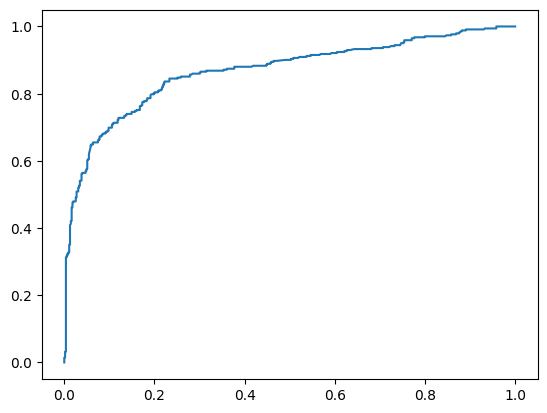

In [28]:
accuracy = classifier.score(X_train, Y_train) * 100
Y_train_pred = classifier.predict_proba(X_train)[:, 1]

FPR, TPR, thresholds = roc_curve(Y_train, Y_train_pred)
AUC = roc_auc_score(Y_train, Y_train_pred)

plt.plot(FPR, TPR)
print("Accuracy: ", "{0:.2f}".format(accuracy))
print("Area Under the Curve: ", "{0:.2f}".format(AUC))

## Limitations of Test Set Evaluation

- We can only compute **training accuracy** on the training set because the test set labels (`Survived`) are hidden.
- To evaluate on the test set:
  1. Predict `Survived` values for the test passengers.
  2. Submit your predictions (CSV with `PassengerId` and `Survived`) to Kaggle.
  3. Kaggle will return the test accuracy and leaderboard ranking to assess model performance.


In [29]:
# Test data prediction
predict = classifier.predict(X_test)
predict = np.round(predict)

# This is how the model predicted
result = test_data.copy()
result["PREDICTION"] = predict
result.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PREDICTION
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
